In [33]:
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset
import os
import sys
sys.path.append(os.path.abspath(".."))
from utils.degree_day_equations import *
from utils.net_cdf_functions import *
from utils.processing_functions import *
#from utils.visualization_functions import *

import pandas as pd
#from visualization_functions import *
import numpy as np
data_path =  "../data/"

I have some .nc data on a server I'd like to access with pydap and xarray. I want only the tmin and tmax variables for some number of dates - that I want to specify with a start date and a n_days. IF n_days is None, I want to select all data to the present. 

Sometimes I want data within some bounding box and sometimes I want data for only a certain point. 

here is an example dataset for jan 1st 2016 - https://thredds.climate.ncsu.edu/thredds/catalog/prism/daily/combo/2016/catalog.html?dataset=prism/daily/combo/2016/PRISM_combo_20160101.nc

the long string at the end is the year, month and date 

can you write me a function to call the data I want and collect into xarray?

In [198]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

def fetch_thredds_data(base_url, start_date, n_days=None, bbox=None, point=None):
    """
    Fetch data from a THREDDS server and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - point: tuple or None, specific point in the format (lon, lat)
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now()
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize an empty list to store datasets
    datasets = []
    
    # Loop through each date and fetch the data
    for date in dates:
        date_str = date.strftime('%Y%m%d')
        url = f"{base_url}/PRISM_combo_{date_str}.nc"
        
        # Open the dataset using xarray
        ds = xr.open_dataset(url)
        #print(ds)
        # Select tmin and tmax variables
        ds = ds[['tmin', 'tmax']]
        #print(ds)
        # Apply bounding box or point selection if specified
        if bbox is not None:
            lon_min, lon_max, lat_min, lat_max = bbox
            ds = ds.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
        elif point is not None:
            lon, lat = point
            ds = ds.sel(longitude=lon, latitude=lat, method='nearest')
        #print(ds)
        # Append the dataset to the list
        datasets.append(ds)
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='t')
    
    return combined_ds

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo/2016"
start_date = "2024-03-01"
n_days = 20
bbox = (-110, -109, 48, 47)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
point = None  # Example point (lon, lat)

data = fetch_thredds_data(base_url, start_date, n_days, bbox, point)
print(data)

OSError: [Errno -90] NetCDF: file not found: 'https://thredds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo/2016/PRISM_combo_20240301.nc'

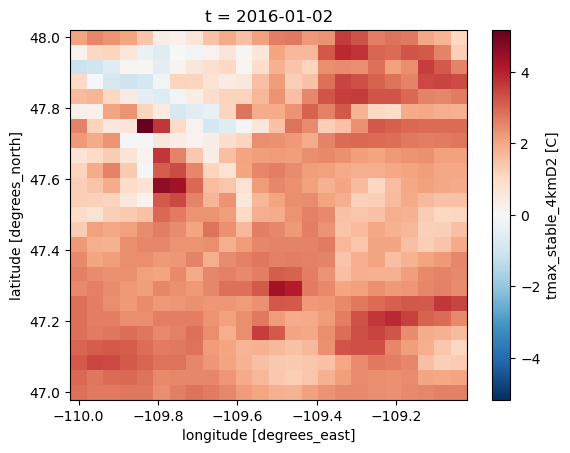

In [115]:
data['tmax'].isel(t=1).plot()

In [240]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

def fetch_thredds_PRISM(base_url, start_date, n_days=None, bbox=None, point=None):
    """
    Fetch data from a THREDDS server and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - point: tuple or None, specific point in the format (lon, lat)
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now()
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize an empty list to store datasets
    datasets = []
    
    # Loop through each date and fetch the data
    for date in dates:
        date_str = date.strftime('%Y%m%d')
        url = f"{base_url}/PRISM_combo_{date_str}.nc"
        
        # Open the dataset using xarray
        ds = xr.open_dataset(url)
        
        # Select tmin and tmax variables
        ds = ds[['tmin', 'tmax']]
        
        # Debug: Print the dataset coordinates before subsetting
        #print(ds.coords)
        
        # Apply bounding box or point selection if specified
        if bbox is not None:
            lon_min, lon_max, lat_min, lat_max = bbox
            # Ensure latitude slice is in the correct order
            ds = ds.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
        elif point is not None:
            lon, lat = point
            ds = ds.sel(longitude=lon, latitude=lat, method='nearest')
        
        # Debug: Print the dataset coordinates after subsetting
        #print(ds.coords)
        
        # Append the dataset to the list
        datasets.append(ds)
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='t')
    
    return combined_ds

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo/2024"
start_date = "2024-03-18"
n_days = 1
bbox = (-110, -109, 34, 33)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
point = None  # Example point (lon, lat)

data = fetch_thredds_data(base_url, start_date, n_days, bbox, point)
print(data)

<xarray.Dataset> Size: 65kB
Dimensions:    (t: 2, latitude: 41, longitude: 49)
Coordinates:
  * longitude  (longitude) float64 392B -110.0 -110.0 -110.0 ... -109.0 -109.0
  * latitude   (latitude) float64 328B 33.0 33.04 33.04 ... 33.96 33.96 34.0
  * t          (t) datetime64[ns] 16B 2024-03-18 2024-03-19
Data variables:
    tmin       (t, latitude, longitude) float64 32kB nan 0.6744 ... -2.931 -3.25
    tmax       (t, latitude, longitude) float64 32kB nan 18.57 ... 4.296 3.176
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t


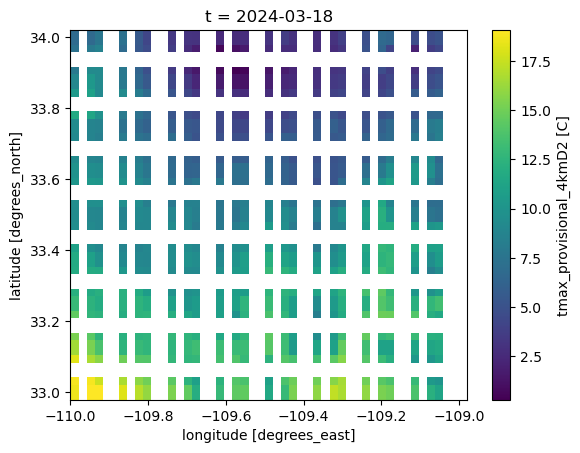

In [241]:
data.tmax.isel(t=0).plot()

In [36]:
test = da_calculate_degree_days(4,999, data)

In [237]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor

def get_indices_for_bbox(ds, bbox):
    """
    Get the indices for the bounding box from the dataset.
    
    Parameters:
    - ds: xarray.Dataset, the dataset to get indices from
    - bbox: tuple, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    
    Returns:
    - tuple of indices (lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx)
    """
    lon_min, lon_max, lat_min, lat_max = bbox
    longitude = ds['longitude']
    latitude = ds['latitude']
    lon_min_idx = (abs(longitude - lon_min)).argmin().values
    lon_max_idx = (abs(longitude - lon_max)).argmin().values
    lat_min_idx = (abs(latitude - lat_min)).argmin().values
    lat_max_idx = (abs(latitude - lat_max)).argmin().values
    return lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx

def fetch_single_day(base_url, date_str, year, lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx):
    """
    Fetch data for a single day from a THREDDS server using OPeNDAP.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - date_str: str, date in the format 'YYYYMMDD'
    - year: str, year in the format 'YYYY'
    - lon_min_idx: int, minimum longitude index
    - lon_max_idx: int, maximum longitude index
    - lat_min_idx: int, minimum latitude index
    - lat_max_idx: int, maximum latitude index
    
    Returns:
    - xarray.Dataset containing the requested data for the specified day
    """
    url = f"{base_url}/{year}/PRISM_combo_{date_str}.nc"
    constraints = f"longitude[{lon_min_idx}:1:{lon_max_idx}],latitude[{lat_min_idx}:1:{lat_max_idx}]"
    opendap_url = f"{url}?tmin,tmax,{constraints}"
    
    # Open the dataset using xarray
    ds = xr.open_dataset(opendap_url)
    
    return ds

def fetch_thredds_PRISM(base_url, start_date, n_days=None, bbox=None, point=None):
    """
    Fetch data from a THREDDS server and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - point: tuple or None, specific point in the format (lon, lat)
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now()
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Open the first file to determine the indices for the bounding box or point
    first_date_str = dates[0].strftime('%Y%m%d')
    first_year = dates[0].strftime('%Y')
    first_url = f"{base_url}/{first_year}/PRISM_combo_{first_date_str}.nc"
    first_ds = xr.open_dataset(first_url)
    
    if bbox is not None:
        lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx = get_indices_for_bbox(first_ds, bbox)
    elif point is not None:
        lon, lat = point
        lon_min_idx = lon_max_idx = (abs(first_ds['longitude'] - lon)).argmin().values
        lat_min_idx = lat_max_idx = (abs(first_ds['latitude'] - lat)).argmin().values
    else:
        raise ValueError("Either bbox or point must be specified.")
    
    # Initialize an empty list to store datasets
    datasets = []
    
    # Use ThreadPoolExecutor to fetch data in parallel
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [
            executor.submit(
                fetch_single_day,
                base_url,
                date.strftime('%Y%m%d'),
                date.strftime('%Y'),
                lon_min_idx,
                lon_max_idx,
                lat_min_idx,
                lat_max_idx
            ) for date in dates
        ]
        for future in futures:
            datasets.append(future.result())
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='time')
    
    return combined_ds

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo"
start_date = "2024-03-18"
n_days = 2
bbox = (-125, -124, 34, 33)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
point = None  # Example point (lon, lat)

data = fetch_thredds_PRISM(base_url, start_date, n_days, bbox, point)
print(data)

<xarray.Dataset> Size: 42MB
Dimensions:    (time: 3, t: 1, latitude_1: 621, longitude_1: 1405,
                longitude: 50, latitude: 41)
Coordinates:
  * longitude  (longitude) float64 400B -125.0 -125.0 -125.0 ... -124.0 -124.0
  * latitude   (latitude) float64 328B 33.0 33.04 33.04 ... 33.96 33.96 34.0
Dimensions without coordinates: time, t, latitude_1, longitude_1
Data variables:
    tmin       (time, t, latitude_1, longitude_1) float64 21MB nan nan ... nan
    tmax       (time, t, latitude_1, longitude_1) float64 21MB nan nan ... nan
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t


In [200]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor

def get_indices_for_bbox(ds, bbox):
    """
    Get the indices for the bounding box from the dataset.
    
    Parameters:
    - ds: xarray.Dataset, the dataset to get indices from
    - bbox: tuple, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    
    Returns:
    - tuple of indices (lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx)
    """
    lon_min, lon_max, lat_min, lat_max = bbox
    longitude = ds['longitude']
    latitude = ds['latitude']
    lon_min_idx = (abs(longitude - lon_min)).argmin().values
    lon_max_idx = (abs(longitude - lon_max)).argmin().values
    lat_min_idx = (abs(latitude - lat_min)).argmin().values
    lat_max_idx = (abs(latitude - lat_max)).argmin().values
    return lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx

def fetch_single_day(base_url, date_str, year, lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx):
    """
    Fetch data for a single day from a THREDDS server using OPeNDAP.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - date_str: str, date in the format 'YYYYMMDD'
    - year: str, year in the format 'YYYY'
    - lon_min_idx: int, minimum longitude index
    - lon_max_idx: int, maximum longitude index
    - lat_min_idx: int, minimum latitude index
    - lat_max_idx: int, maximum latitude index
    
    Returns:
    - xarray.Dataset containing the requested data for the specified day
    """
    url = f"{base_url}/{year}/PRISM_combo_{date_str}.nc"
    constraints = (
        f"t[0:1:0],"
        f"tmin[0:1:0][0:1:0][0:1:0],"
        f"tmax[0:1:0][0:1:0][0:1:0],"
        f"longitude[{lon_min_idx}:1:{lon_max_idx}],"
        f"latitude[{lat_max_idx}:1:{lat_min_idx}]"
    )
    opendap_url = f"{url}?{constraints}"
    
    # Open the dataset using xarray
    ds = xr.open_dataset(opendap_url)
    
    return ds

def fetch_thredds_PRISM(base_url, start_date, n_days=None, bbox=None, point=None):
    """
    Fetch data from a THREDDS server and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - point: tuple or None, specific point in the format (lon, lat)
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now()
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Open the first file to determine the indices for the bounding box or point
    first_date_str = dates[0].strftime('%Y%m%d')
    first_year = dates[0].strftime('%Y')
    first_url = f"{base_url}/{first_year}/PRISM_combo_{first_date_str}.nc"
    first_ds = xr.open_dataset(first_url)
    
    if bbox is not None:
        lon_min_idx, lon_max_idx, lat_min_idx, lat_max_idx = get_indices_for_bbox(first_ds, bbox)
    elif point is not None:
        lon, lat = point
        lon_min_idx = lon_max_idx = (abs(first_ds['longitude'] - lon)).argmin().values
        lat_min_idx = lat_max_idx = (abs(first_ds['latitude'] - lat)).argmin().values
    else:
        raise ValueError("Either bbox or point must be specified.")
    
    # Initialize an empty list to store datasets
    datasets = []
    
    # Use ThreadPoolExecutor to fetch data in parallel
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = [
            executor.submit(
                fetch_single_day,
                base_url,
                date.strftime('%Y%m%d'),
                date.strftime('%Y'),
                lon_min_idx,
                lon_max_idx,
                lat_min_idx,
                lat_max_idx
            ) for date in dates
        ]
        for future in futures:
            datasets.append(future.result())
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='t')
    
    return combined_ds

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/dodsC/prism/daily/combo"
start_date = "2016-01-01"
n_days = 100
bbox = (-110   , -109, 33, 34)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
point = None  # Example point (lon, lat)

data = fetch_thredds_PRISM(base_url, start_date, n_days, bbox, point)
print(data)

<xarray.Dataset> Size: 3kB
Dimensions:    (t: 101, latitude_1: 1, longitude_1: 1, longitude: 25,
                latitude: 25)
Coordinates:
  * t          (t) datetime64[ns] 808B 2016-01-01 2016-01-02 ... 2016-04-10
  * longitude  (longitude) float64 200B -110.0 -110.0 -109.9 ... -109.0 -109.0
  * latitude   (latitude) float64 200B 34.0 33.96 33.92 ... 33.08 33.04 33.0
Dimensions without coordinates: latitude_1, longitude_1
Data variables:
    tmin       (t, latitude_1, longitude_1) float64 808B nan nan nan ... nan nan
    tmax       (t, latitude_1, longitude_1) float64 808B nan nan nan ... nan nan
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t


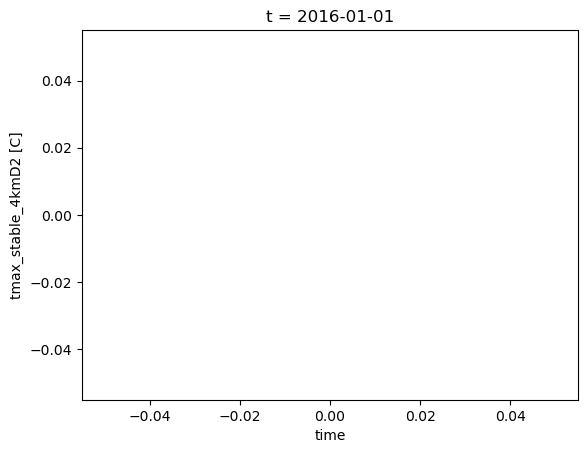

In [100]:
data.tmax.isel(t=0).plot()

In [121]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

def fetch_ncss_data(base_url, start_date, n_days=None, bbox=None, variables=None):
    """
    Fetch data from a THREDDS server using NCSS and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - variables: list or None, list of variables to fetch
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now()
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize an empty list to store datasets
    datasets = []
    
    # Loop through each date and fetch the data
    for date in dates:
        date_str = date.strftime('%Y-%m-%dT00:00:00Z')
        year = date.strftime('%Y')
        url = f"{base_url}/{year}/PRISM_combo_{date.strftime('%Y%m%d')}.nc"
        
        # Construct the NCSS URL
        var_params = "&".join([f"var={var}" for var in variables])
        ncss_url = (
            f"{url}?{var_params}"
            f"&north={bbox[3]}&west={bbox[0]}&east={bbox[1]}&south={bbox[2]}"
            f"&horizStride=1&time_start={date_str}&time_end={date_str}&&&accept=netcdf4ext&addLatLon=true"
        )
        
        # Open the dataset using xarray
        ds = xr.open_dataset(ncss_url)
        
        # Append the dataset to the list
        datasets.append(ds)
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='time')
    
    return combined_ds

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/ncss/grid/prism/daily/combo"
start_date = "2024-01-01"
n_days = 10
bbox = (-125, -124, 34, 33)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
variables = ['tmin', 'tmax']

data = fetch_ncss_data(base_url, start_date, n_days, bbox, variables)
print(data)

OSError: [Errno -75] NetCDF: Malformed or unexpected Constraint: 'https://thredds.climate.ncsu.edu/thredds/ncss/grid/prism/daily/combo/2024/PRISM_combo_20240101.nc?var=tmin&var=tmax&north=33&west=-125&east=-124&south=34&horizStride=1&time_start=2024-01-01T00:00:00Z&time_end=2024-01-01T00:00:00Z&&&accept=netcdf4ext&addLatLon=true'

In [1]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO

def fetch_ncss_data(base_url, start_date, n_days=None, bbox=None, variables=None):
    """
    Fetch data from a THREDDS server using NCSS and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - variables: list or None, list of variables to fetch
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now()
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize an empty list to store datasets
    datasets = []
    
    # Loop through each date and fetch the data
    for date in dates:
        date_str = date.strftime('%Y-%m-%dT00:00:00Z')
        year = date.strftime('%Y')
        url = f"{base_url}/{year}/PRISM_combo_{date.strftime('%Y%m%d')}.nc"
        
        # Construct the NCSS URL
        var_params = "&".join([f"var={var}" for var in variables])
        ncss_url = (
            f"{url}?{var_params}"
            f"&north={bbox[3]}&west={bbox[0]}&east={bbox[1]}&south={bbox[2]}"
            f"&horizStride=1&time_start={date_str}&time_end={date_str}&accept=netcdf4ext&addLatLon=true"
        )
        #ds = xr.open_dataset(ncss_url)
        # Fetch the data using requests
        response = requests.get(ncss_url)
        response.raise_for_status()  # Raise an error for bad status codes
        
        # Load the dataset into xarray
        ds = xr.open_dataset(BytesIO(response.content), engine='h5netcdf')
        
        # Append the dataset to the list
        datasets.append(ds)
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='t', join = 'override')
    #combined_ds = datasets[0].combine_first(datasets[1])
    return combined_ds

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/ncss/grid/prism/daily/combo"
start_date = "2021-01-01"
n_days = 100
bbox = (-110.01, -109.02, 41.01, 42.01)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
variables = ['tmin', 'tmax']

data = fetch_ncss_data(base_url, start_date, n_days = 100, bbox = bbox, variables = variables )
print(data)

<xarray.Dataset> Size: 1MB
Dimensions:    (t: 101, latitude: 25, longitude: 25)
Coordinates:
  * t          (t) datetime64[ns] 808B 2021-01-01 2021-01-02 ... 2021-04-11
  * latitude   (latitude) float64 200B 42.0 41.96 41.92 ... 41.08 41.04 41.0
  * longitude  (longitude) float64 200B -110.0 -110.0 -109.9 ... -109.0 -109.0
Data variables:
    tmax       (t, latitude, longitude) float64 505kB 0.192 -0.117 ... 12.41
    tmin       (t, latitude, longitude) float64 505kB -18.18 -18.11 ... -5.259
Attributes:
    Conventions:         CF-1.0
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  40.979166666666664
    geospatial_lat_max:  42.020833333333336
    geospatial_lon_min:  -110.02083333291459
    geospatial_lon_max:  -108.979166666242


In [1]:
import xarray as xr
import time
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed

def fetch_single_day_ncss(ncss_url):
    """
    Fetch data for a single day from a THREDDS server using NCSS.
    
    Parameters:
    - ncss_url: str, the NCSS URL to fetch data from
    
    Returns:
    - xarray.Dataset containing the requested data for the specified day
    """
    # Fetch the data using requests
    response = requests.get(ncss_url)
    response.raise_for_status()  # Raise an error for bad status codes
    
    # Load the dataset into xarray
    ds = xr.open_dataset(BytesIO(response.content), engine='h5netcdf')
    
    return ds

def fetch_ncss_data(base_url, start_date, n_days=None, bbox=None, variables=None, point = None):
    """
    Fetch data from a THREDDS server using NCSS and collect it into an xarray Dataset.
    
    Parameters:
    - base_url: str, base URL of the THREDDS server
    - start_date: str, start date in the format 'YYYY-MM-DD'
    - n_days: int or None, number of days to fetch data for. If None, fetch all data to the present.
    - bbox: tuple or None, bounding box in the format (lon_min, lon_max, lat_min, lat_max)
    - variables: list or None, list of variables to fetch
    
    Returns:
    - xarray.Dataset containing the requested data
    """
    # Convert start_date to datetime
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # Calculate end_date
    if n_days is None:
        end_date = datetime.now() - timedelta(days=2)
    else:
        end_date = start_date + timedelta(days=n_days)
    
    # Generate list of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize an empty list to store NCSS URLs
    ncss_urls = []
    
    # Loop through each date and construct the NCSS URL
    for date in dates:
        date_str = date.strftime('%Y-%m-%dT00:00:00Z')
        year = date.strftime('%Y')
        url = f"{base_url}/{year}/PRISM_combo_{date.strftime('%Y%m%d')}.nc"
        
        # Construct the NCSS URL
        var_params = "&".join([f"var={var}" for var in variables])
        if bbox:
            ncss_url = (
            f"{url}?{var_params}"
            f"&north={bbox[3]}&west={bbox[0]}&east={bbox[1]}&south={bbox[2]}"
            f"&horizStride=1&time_start={date_str}&time_end={date_str}&accept=netcdf4ext&addLatLon=true"
            )
        elif point:
            ncss_url = (
                f"{url}?{var_params}"
                f"&north={point[1]}&west={point[0]}&east={point[0]}&south={point[1]}"
                f"&horizStride=1&time_start={date_str}&time_end={date_str}&accept=netcdf4ext&addLatLon=true"
            )
        else:
            raise ValueError("Either bbox or point must be provided.")
            # Append the NCSS URL to the list

        ncss_urls.append(ncss_url)
    
    # Initialize an empty list to store datasets
    datasets = [None] * len(ncss_urls)
    
    # Use ThreadPoolExecutor to fetch data in parallel
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_index = {executor.submit(fetch_single_day_ncss, url): i for i, url in enumerate(ncss_urls)}
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                ds = future.result()
                datasets[index] = ds
            except Exception as e:

                try:
                    #wait 5 seconds
                    time.sleep(3)
                    ds = future.result()
                    datasets.append(ds)
                except:
                   print(e)
                   print(f"Error fetching data for URL {ncss_urls[index]}: {e}")
    
    # Combine all datasets into a single xarray Dataset
    combined_ds = xr.concat(datasets, dim='t', join = 'override')
    
    return combined_ds, datasets

# Example usage
base_url = "https://thredds.climate.ncsu.edu/thredds/ncss/grid/prism/daily/combo"
start_date = "2021-01-01"
n_days = 10
bbox = (-122.05, -121.31, 37.28, 38.59)  # Example bounding box (lon_min, lon_max, lat_min, lat_max)
variables = ['tmin', 'tmax']

data, datasets = fetch_ncss_data(base_url, start_date, n_days = 150, bbox = bbox, variables = variables, point = None)
print(data)

<xarray.Dataset> Size: 1MB
Dimensions:    (t: 151, latitude: 32, longitude: 19)
Coordinates:
  * t          (t) datetime64[ns] 1kB 2021-01-01 2021-01-02 ... 2021-05-31
  * latitude   (latitude) float64 256B 38.58 38.54 38.5 ... 37.38 37.33 37.29
  * longitude  (longitude) float64 152B -122.0 -122.0 -122.0 ... -121.3 -121.3
Data variables:
    tmax       (t, latitude, longitude) float64 734kB 17.0 16.47 ... 32.65 32.75
    tmin       (t, latitude, longitude) float64 734kB 2.859 3.006 ... 11.55 11.9
Attributes:
    Conventions:         CF-1.0
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  37.270833333333336
    geospatial_lat_max:  38.60416666666667
    geospatial_lon_min:  -122.06249999964982
    geospatial_lon_max:  -121.27083333297864
